In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

%load_ext autoreload
%autoreload 2

In [2]:
from utils import load_dicom_image, load_dicom_images_3d

In [6]:
train_data_directory = 'D:/brain-classification-data/train'
data_directory = 'D:/brain-classification-data'

In [7]:
IMAGE_SIZE = 128
NUM_IMAGES = 64

(1, 128, 128, 64)
0.0 1.0 0.07992366480843072 0.00023943086165344952
Dimension of the CT scan is: (128, 128, 64)


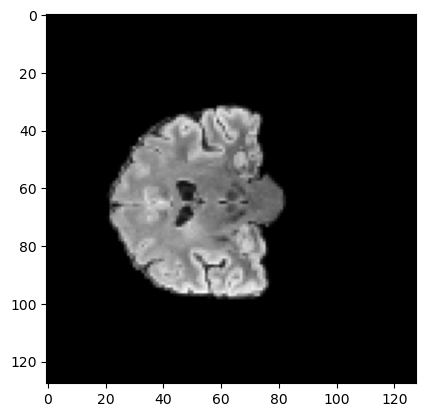

In [8]:
a = load_dicom_images_3d("00000", num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE)
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

In [9]:
df_train_labels = pd.read_csv('data/train_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [10]:
print(len(os.listdir(train_data_directory)))

585


In [47]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.array([train.T for train in total_training_scans[:80]])
x_val = np.array([train.T for train in total_training_scans[80:]])

In [49]:
x_train.shape, x_val.shape

((80, 64, 128, 128, 1), (20, 64, 128, 128, 1))

In [50]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

In [54]:
total_training_labels = total_training_labels[:100]
y_train = total_training_labels[:80]
y_val = total_training_labels[80:]

In [55]:
def model(width=128, height=128, depth=64):
    inputs = keras.Input((depth,width, height,1))
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="cnn")
    return model

model = model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 128, 128, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 62, 126, 126, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 31, 63, 63, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 31, 63, 63, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 29, 61, 61, 64)    110656    
                                                             

In [57]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 10
model.fit(
    tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4),
    validation_data=tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(4),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
20/20 - 45s - loss: 0.6715 - acc: 0.6500 - val_loss: 0.7565 - val_acc: 0.4500 - 45s/epoch - 2s/step
Epoch 2/10
20/20 - 44s - loss: 0.5273 - acc: 0.7750 - val_loss: 0.8586 - val_acc: 0.4500 - 44s/epoch - 2s/step
Epoch 3/10
20/20 - 45s - loss: 0.4788 - acc: 0.8375 - val_loss: 0.9517 - val_acc: 0.4500 - 45s/epoch - 2s/step
Epoch 4/10
20/20 - 46s - loss: 0.4427 - acc: 0.8250 - val_loss: 1.0646 - val_acc: 0.4500 - 46s/epoch - 2s/step
Epoch 5/10
20/20 - 45s - loss: 0.3990 - acc: 0.8750 - val_loss: 1.1316 - val_acc: 0.4500 - 45s/epoch - 2s/step
Epoch 6/10
20/20 - 45s - loss: 0.3690 - acc: 0.8750 - val_loss: 1.2681 - val_acc: 0.4500 - 45s/epoch - 2s/step
Epoch 7/10
20/20 - 46s - loss: 0.3406 - acc: 0.9125 - val_loss: 1.2241 - val_acc: 0.4500 - 46s/epoch - 2s/step
Epoch 8/10
20/20 - 45s - loss: 0.2989 - acc: 0.9000 - val_loss: 1.4415 - val_acc: 0.4500 - 45s/epoch - 2s/step
Epoch 9/10
20/20 - 45s - loss: 0.2440 - acc: 0.9500 - val_loss: 1.4621 - val_acc: 0.4500 - 45s/epoch - 2s/step
E